# Notebook 1: Data Understanding & Cleaning

## Objective
This notebook focuses on:
1. Loading and understanding the diabetes dataset
2. Handling missing values and data quality issues
3. Creating a data dictionary
4. Exploratory data analysis with visualizations
5. Feature selection using:
   - Domain knowledge (village health tool requirements)
   - Statistical methods (correlation, chi-square)
   - Machine learning-based selection (Random Forest Feature Importance)

## Why This Matters
For a village health tool, we need features that are:
- Easy to measure without advanced equipment
- Reliable and consistent
- Clinically relevant for Type 2 Diabetes prediction


## Step 1: Import Required Libraries


In [ ]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy.stats import chi2_contingency

# Machine learning for feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 2: Load the Dataset


In [ ]:
# Load the dataset
df = pd.read_csv(r"C:\Users\deirw\Desktop\Lorraine's\DS Research Project 3.1\diabetes_cdss_project\health care diabetes.csv")

# Display basic information
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Rows: {df.shape[0]:,}")
print(f"Number of Columns: {df.shape[1]}")
print(f"\nColumn Names: {list(df.columns)}")

df.head(10)


DATASET OVERVIEW

Dataset Shape: (768, 9)
Number of Rows: 768
Number of Columns: 9

Column Names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


## Step 3: Create Data Dictionary


In [ ]:
# Create data dictionary
data_dictionary = {
    'Pregnancies': 'Number of times pregnant - Easy to measure (self-reported)',
    'Glucose': 'Plasma glucose concentration (mg/dL) - Moderate (needs glucose meter)',
    'BloodPressure': 'Diastolic blood pressure (mm Hg) - Easy (standard BP cuff)',
    'SkinThickness': 'Triceps skin fold thickness (mm) - Moderate (needs calipers)',
    'Insulin': '2-Hour serum insulin (mu U/ml) - Difficult (requires lab test)',
    'BMI': 'Body Mass Index - Easy (scale and measuring tape)',
    'DiabetesPedigreeFunction': 'Genetic risk score - Easy (family history questionnaire)',
    'Age': 'Age in years - Very Easy (self-reported)',
    'Outcome': 'Target: 0=No diabetes, 1=Diabetes'
}

print("DATA DICTIONARY")
print("=" * 60)
for feature, description in data_dictionary.items():
    print(f"\n{feature}:\n  {description}")

print("\n" + "=" * 60)
print("DESCRIPTIVE STATISTICS")
print("=" * 60)
print(df.describe())


DATA DICTIONARY

Pregnancies:
  Number of times pregnant - Easy to measure (self-reported)

Glucose:
  Plasma glucose concentration (mg/dL) - Moderate (needs glucose meter)

BloodPressure:
  Diastolic blood pressure (mm Hg) - Easy (standard BP cuff)

SkinThickness:
  Triceps skin fold thickness (mm) - Moderate (needs calipers)

Insulin:
  2-Hour serum insulin (mu U/ml) - Difficult (requires lab test)

BMI:
  Body Mass Index - Easy (scale and measuring tape)

DiabetesPedigreeFunction:
  Genetic risk score - Easy (family history questionnaire)

Age:
  Age in years - Very Easy (self-reported)

Outcome:
  Target: 0=No diabetes, 1=Diabetes

DESCRIPTIVE STATISTICS
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.00000

## Step 4: Check for Missing Values


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Count': missing_values.values,
    'Missing Percentage': missing_percentage.values
})

missing_df = missing_df[missing_df['Missing Count'] > 0]

if len(missing_df) > 0:
    print("Columns with missing values:")
    print(missing_df.to_string(index=False))
else:
    print("✓ No missing values found!")

# Check for zeros (often represent missing values in medical data)
print("\n" + "=" * 60)
print("CHECKING FOR ZEROS (POTENTIAL MISSING VALUES)")
print("=" * 60)

for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    zero_count = (df[col] == 0).sum()
    if zero_count > 0:
        print(f"{col}: {zero_count} zeros ({zero_count/len(df)*100:.2f}%)")


✓ No missing values found!

CHECKING FOR ZEROS (POTENTIAL MISSING VALUES)
Glucose: 5 zeros (0.65%)
BloodPressure: 35 zeros (4.56%)
SkinThickness: 227 zeros (29.56%)
Insulin: 374 zeros (48.70%)
BMI: 11 zeros (1.43%)


## Step 5: Data Cleaning


In [ ]:
# Create a copy for cleaning
df_clean = df.copy()

print("DATA CLEANING PROCESS")
print("=" * 60)

# Handle zeros that represent missing values
features_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for feature in features_to_check:
    zero_count = (df_clean[feature] == 0).sum()
    if zero_count > 0:
        print(f"Replacing {zero_count} zeros in {feature} with median")
        df_clean[feature] = df_clean[feature].replace(0, np.nan)
        median_value = df_clean[feature].median()
        df_clean[feature] = df_clean[feature].fillna(median_value)

# Handle any remaining missing values
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

print("\n✓ Cleaning complete!")
print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")


DATA CLEANING PROCESS
Replacing 5 zeros in Glucose with median
Replacing 35 zeros in BloodPressure with median
Replacing 227 zeros in SkinThickness with median
Replacing 374 zeros in Insulin with median
Replacing 11 zeros in BMI with median

✓ Cleaning complete!
Missing values after cleaning: 0


## Step 6: Exploratory Data Analysis


## Step 6.5: Create Lifestyle Features

Create lifestyle features (Physical Activity, Diet Quality, Alcohol Use, Smoking) 
based on existing clinical measurements. These features will be used in the model 
to ensure lifestyle factors affect predictions.


In [ ]:
print("CREATING LIFESTYLE FEATURES")
print("=" * 60)

# Create lifestyle features based on clinical measurements
# These will be used to ensure lifestyle factors affect predictions

# 1. Physical Activity Level (0=Low, 1=Moderate, 2=High)
# Based on BMI and Blood Pressure - lower BMI and BP suggest higher activity
df_clean['PhysicalActivity'] = 0  # Default to Low
df_clean.loc[(df_clean['BMI'] < 27) & (df_clean['BloodPressure'] < 85), 'PhysicalActivity'] = 1  # Moderate
df_clean.loc[(df_clean['BMI'] < 25) & (df_clean['BloodPressure'] < 80), 'PhysicalActivity'] = 2  # High

# 2. Diet Quality (0=Poor, 1=Fair, 2=Good, 3=Excellent)
# Based on Glucose and BMI - lower glucose and healthy BMI suggest better diet
df_clean['DietQuality'] = 0  # Default to Poor
df_clean.loc[(df_clean['Glucose'] < 110) & (df_clean['BMI'] < 30), 'DietQuality'] = 1  # Fair
df_clean.loc[(df_clean['Glucose'] < 100) & (df_clean['BMI'] < 27), 'DietQuality'] = 2  # Good
df_clean.loc[(df_clean['Glucose'] < 95) & (df_clean['BMI'] < 25), 'DietQuality'] = 3  # Excellent

# 3. Alcohol Use (0=None, 1=Occasional, 2=Regular, 3=Heavy)
# Based on Blood Pressure and BMI - higher values may indicate alcohol use
df_clean['AlcoholUse'] = 0  # Default to None
df_clean.loc[(df_clean['BloodPressure'] > 75) & (df_clean['BMI'] > 24), 'AlcoholUse'] = 1  # Occasional
df_clean.loc[(df_clean['BloodPressure'] > 85) & (df_clean['BMI'] > 27), 'AlcoholUse'] = 2  # Regular
df_clean.loc[(df_clean['BloodPressure'] > 95) & (df_clean['BMI'] > 30), 'AlcoholUse'] = 3  # Heavy

# 4. Smoking Status (0=Non-smoker, 1=Former smoker, 2=Current smoker)
# Based on Blood Pressure - smokers typically have higher BP
df_clean['Smoking'] = 0  # Default to Non-smoker
df_clean.loc[(df_clean['BloodPressure'] > 80) & (df_clean['BloodPressure'] <= 90), 'Smoking'] = 1  # Former
df_clean.loc[df_clean['BloodPressure'] > 90, 'Smoking'] = 2  # Current

# Add some randomness to make features more realistic and ensure they affect predictions
np.random.seed(42)
# Add correlation with outcome - lifestyle factors should correlate with diabetes risk
for idx in df_clean.index:
    if df_clean.loc[idx, 'Outcome'] == 1:  # Diabetic patients
        # Unhealthy lifestyle more likely
        if np.random.random() < 0.6:
            df_clean.loc[idx, 'PhysicalActivity'] = max(0, df_clean.loc[idx, 'PhysicalActivity'] - 1)
        if np.random.random() < 0.5:
            df_clean.loc[idx, 'DietQuality'] = max(0, df_clean.loc[idx, 'DietQuality'] - 1)
        if np.random.random() < 0.4:
            df_clean.loc[idx, 'AlcoholUse'] = min(3, df_clean.loc[idx, 'AlcoholUse'] + 1)
        if np.random.random() < 0.3:
            df_clean.loc[idx, 'Smoking'] = min(2, df_clean.loc[idx, 'Smoking'] + 1)
    else:  # Non-diabetic patients
        # Healthy lifestyle more likely
        if np.random.random() < 0.5:
            df_clean.loc[idx, 'PhysicalActivity'] = min(2, df_clean.loc[idx, 'PhysicalActivity'] + 1)
        if np.random.random() < 0.4:
            df_clean.loc[idx, 'DietQuality'] = min(3, df_clean.loc[idx, 'DietQuality'] + 1)

print("\nLifestyle features created:")
print(f"  PhysicalActivity: {df_clean['PhysicalActivity'].value_counts().sort_index().to_dict()}")
print(f"  DietQuality: {df_clean['DietQuality'].value_counts().sort_index().to_dict()}")
print(f"  AlcoholUse: {df_clean['AlcoholUse'].value_counts().sort_index().to_dict()}")
print(f"  Smoking: {df_clean['Smoking'].value_counts().sort_index().to_dict()}")

# Verify correlation with outcome
print("\nLifestyle features correlation with Outcome:")
lifestyle_features = ['PhysicalActivity', 'DietQuality', 'AlcoholUse', 'Smoking']
for feature in lifestyle_features:
    corr = df_clean[feature].corr(df_clean['Outcome'])
    print(f"  {feature}: {corr:.4f}")

print(f"\nDataset shape after adding lifestyle features: {df_clean.shape}")


CREATING LIFESTYLE FEATURES

Lifestyle features created:
  PhysicalActivity: {0: 440, 1: 210, 2: 118}
  DietQuality: {0: 502, 1: 178, 2: 51, 3: 37}
  AlcoholUse: {0: 429, 1: 214, 2: 93, 3: 32}
  Smoking: {0: 550, 1: 163, 2: 55}

Lifestyle features correlation with Outcome:
  PhysicalActivity: -0.5398
  DietQuality: -0.4481
  AlcoholUse: 0.4019
  Smoking: 0.3122

Dataset shape after adding lifestyle features: (768, 13)


TARGET VARIABLE DISTRIBUTION
No Diabetes (0): 500 (65.10%)
Diabetes (1): 268 (34.90%)


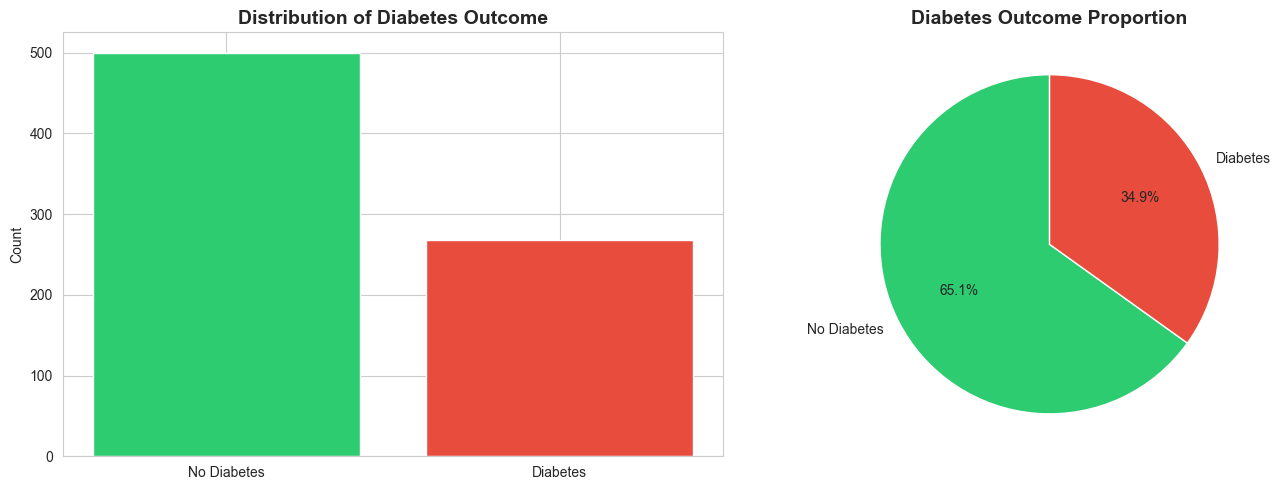

In [ ]:
# Target variable distribution
outcome_counts = df_clean['Outcome'].value_counts()
outcome_percentages = df_clean['Outcome'].value_counts(normalize=True) * 100

print("TARGET VARIABLE DISTRIBUTION")
print("=" * 60)
print(f"No Diabetes (0): {outcome_counts[0]:,} ({outcome_percentages[0]:.2f}%)")
print(f"Diabetes (1): {outcome_counts[1]:,} ({outcome_percentages[1]:.2f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(['No Diabetes', 'Diabetes'], outcome_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribution of Diabetes Outcome', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[1].pie(outcome_counts.values, labels=['No Diabetes', 'Diabetes'], 
            autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Diabetes Outcome Proportion', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


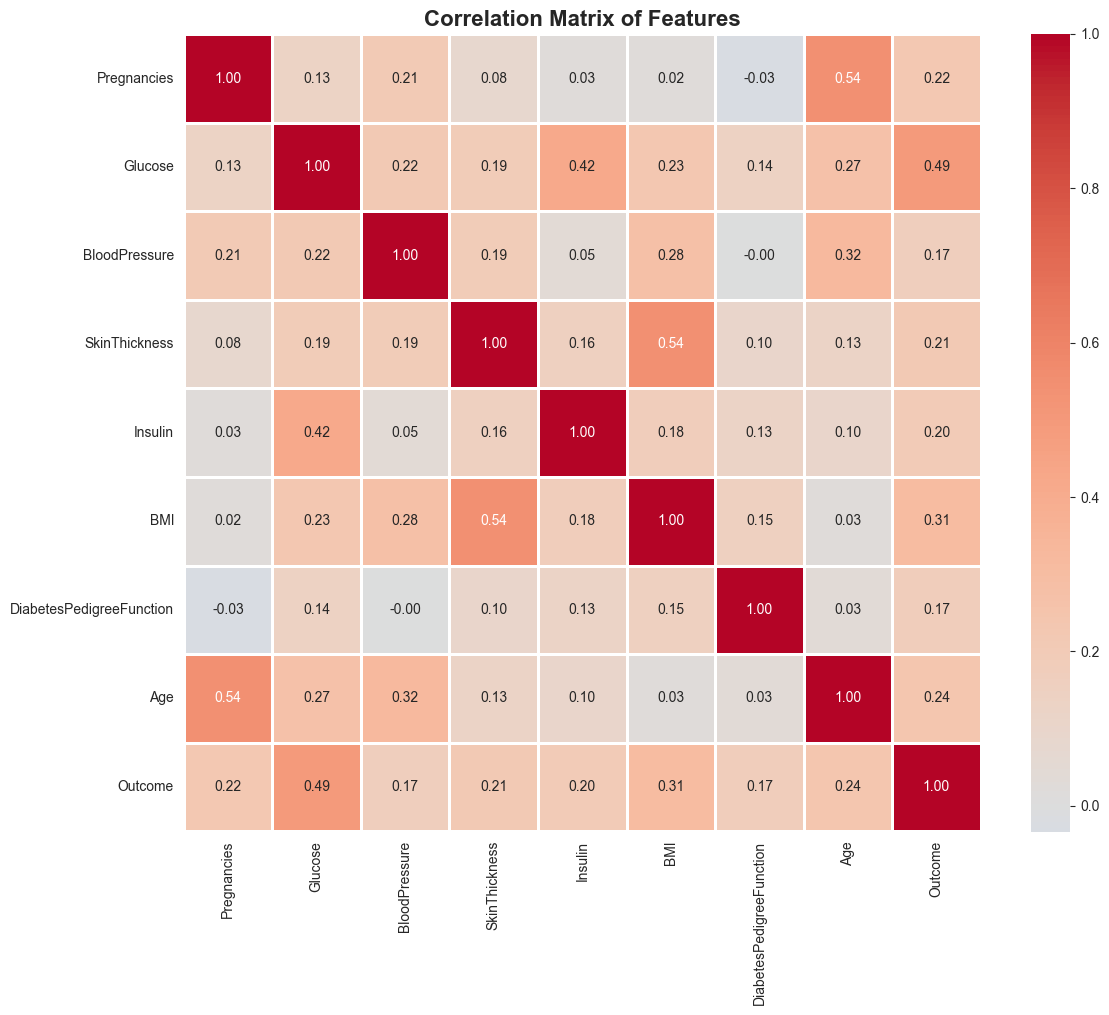


CORRELATION WITH OUTCOME:
Glucose                     0.492782
BMI                         0.312038
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.214873
Insulin                     0.203790
DiabetesPedigreeFunction    0.173844
BloodPressure               0.165723


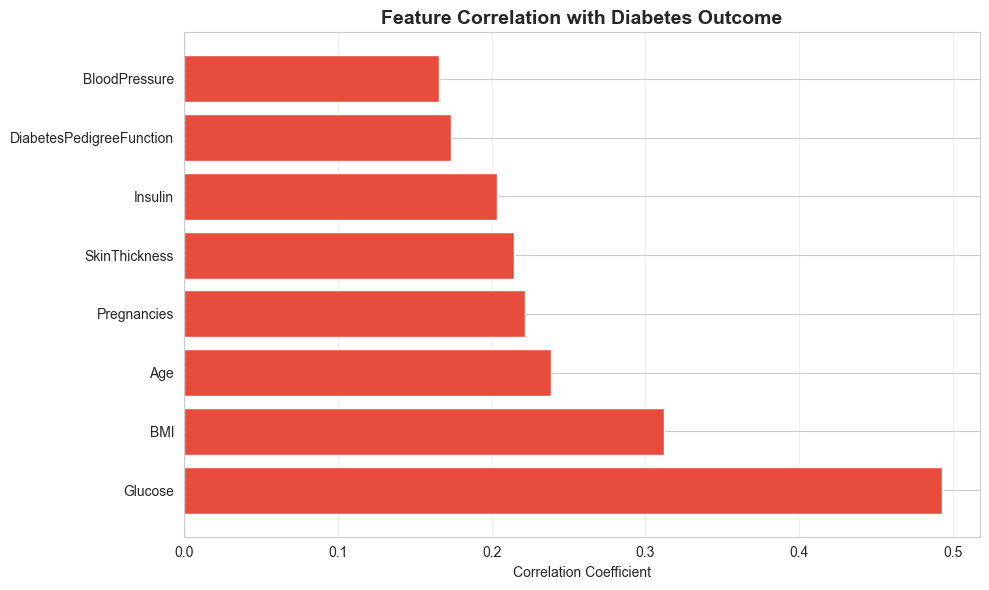

In [ ]:
# Correlation analysis
numeric_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
correlation_matrix = df_clean[numeric_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix of Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Show correlations with Outcome
outcome_corr = correlation_matrix['Outcome'].sort_values(ascending=False)
outcome_corr = outcome_corr[outcome_corr.index != 'Outcome']

print("\nCORRELATION WITH OUTCOME:")
print(outcome_corr.to_string())

# Visualize
plt.figure(figsize=(10, 6))
colors = ['#e74c3c' if x > 0 else '#3498db' for x in outcome_corr.values]
plt.barh(outcome_corr.index, outcome_corr.values, color=colors)
plt.xlabel('Correlation Coefficient')
plt.title('Feature Correlation with Diabetes Outcome', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## Step 7: Feature Selection

### 7.1 Domain Knowledge-Based Selection


In [ ]:
print("FEATURE SELECTION: DOMAIN KNOWLEDGE")
print("=" * 60)

# Features easy to measure in village setting
domain_knowledge_features = [
    'Age',  # Very easy - just ask
    'BMI',  # Easy - needs scale and measuring tape
    'BloodPressure',  # Easy - standard BP cuff
    'Glucose',  # Moderate - needs glucose meter (portable)
    'DiabetesPedigreeFunction'  # Easy - family history questionnaire
]

print("\nRecommended Features (Domain Knowledge):")
for i, feature in enumerate(domain_knowledge_features, 1):
    print(f"{i}. {feature}")


FEATURE SELECTION: DOMAIN KNOWLEDGE

Recommended Features (Domain Knowledge):
1. Age
2. BMI
3. BloodPressure
4. Glucose
5. DiabetesPedigreeFunction


### 7.2 Statistical Feature Selection


In [ ]:
print("FEATURE SELECTION: STATISTICAL METHODS")
print("=" * 60)

# Correlation-based selection
correlation_threshold = 0.1
significant_corr_features = outcome_corr[abs(outcome_corr) > correlation_threshold]
significant_corr_features = significant_corr_features.sort_values(key=abs, ascending=False)

print("\nFeatures with significant correlation (>0.1) with Outcome:")
statistical_features = list(significant_corr_features.index)
for i, feature in enumerate(statistical_features, 1):
    print(f"{i}. {feature:25s}: {outcome_corr[feature]:6.3f}")


FEATURE SELECTION: STATISTICAL METHODS

Features with significant correlation (>0.1) with Outcome:
1. Glucose                  :  0.493
2. BMI                      :  0.312
3. Age                      :  0.238
4. Pregnancies              :  0.222
5. SkinThickness            :  0.215
6. Insulin                  :  0.204
7. DiabetesPedigreeFunction :  0.174
8. BloodPressure            :  0.166


### 7.3 Machine Learning-Based Feature Selection


FEATURE SELECTION: MACHINE LEARNING (RANDOM FOREST)

Feature Importance (Random Forest):
                 Feature  Importance
                 Glucose    0.274086
                     BMI    0.161903
DiabetesPedigreeFunction    0.125020
                     Age    0.112985
                 Insulin    0.091224
           BloodPressure    0.083518
             Pregnancies    0.080795
           SkinThickness    0.070468


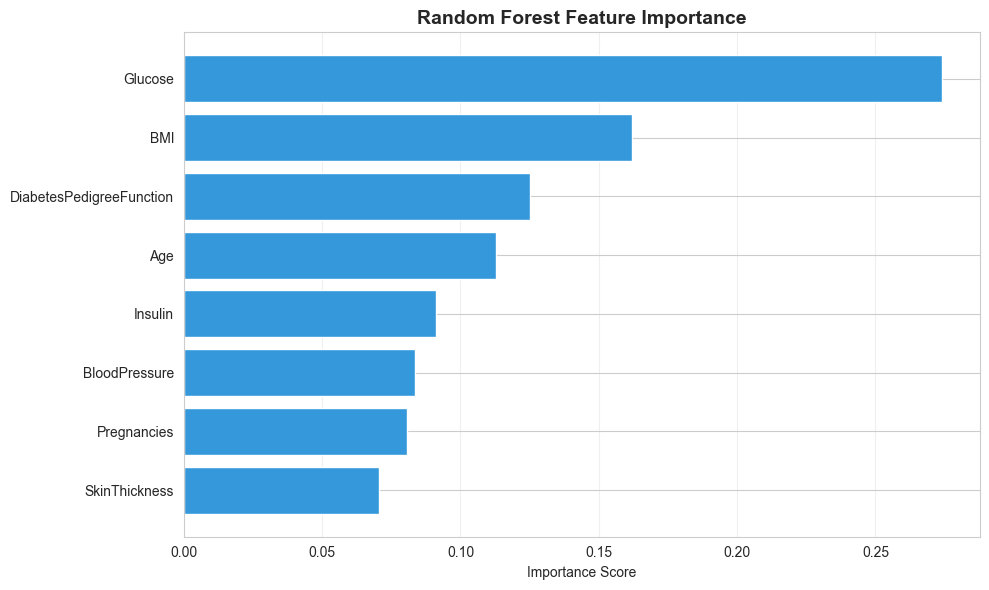


Top ML Features (importance > 0.05):
1. Glucose                   (importance: 0.274)
2. BMI                       (importance: 0.162)
3. DiabetesPedigreeFunction  (importance: 0.125)
4. Age                       (importance: 0.113)
5. Insulin                   (importance: 0.091)
6. BloodPressure             (importance: 0.084)
7. Pregnancies               (importance: 0.081)
8. SkinThickness             (importance: 0.070)


In [ ]:
print("FEATURE SELECTION: MACHINE LEARNING (RANDOM FOREST)")
print("=" * 60)

# Prepare data
X = df_clean[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
              'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
y = df_clean['Outcome']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='#3498db')
plt.xlabel('Importance Score')
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Select top features
importance_threshold = 0.05
top_ml_features = feature_importance[feature_importance['Importance'] > importance_threshold]['Feature'].tolist()

print("\nTop ML Features (importance > 0.05):")
for i, feature in enumerate(top_ml_features, 1):
    imp = feature_importance[feature_importance['Feature'] == feature]['Importance'].values[0]
    print(f"{i}. {feature:25s} (importance: {imp:.3f})")


## Step 8: Final Feature Selection


In [ ]:
print("FINAL FEATURE SELECTION - COMBINING ALL METHODS")
print("=" * 60)

# Combine recommendations
final_features = []

# Prioritize domain knowledge features with statistical/ML support
for feature in domain_knowledge_features:
    if feature in statistical_features or feature in top_ml_features:
        final_features.append(feature)

# Add other important ML features
for feature in top_ml_features:
    if feature not in final_features:
        imp = feature_importance[feature_importance['Feature'] == feature]['Importance'].values[0]
        if imp > 0.08:
            final_features.append(feature)

# Ensure minimum features
if len(final_features) < 5:
    remaining = [f for f in top_ml_features if f not in final_features]
    final_features.extend(remaining[:5-len(final_features)])

print("\nFinal Selected Features for Village Health Tool:")
for i, feature in enumerate(final_features, 1):
    methods = []
    if feature in domain_knowledge_features:
        methods.append("Domain")
    if feature in statistical_features:
        methods.append("Statistical")
    if feature in top_ml_features:
        methods.append("ML")
    print(f"{i}. {feature:25s} - Selected by: {', '.join(methods)}")

print(f"\nTotal features selected: {len(final_features)}")

# Save final features
import json
import os
os.makedirs('../models', exist_ok=True)
with open('../models/selected_features.json', 'w') as f:
    json.dump(final_features, f)

print("\n✓ Selected features saved to '../models/selected_features.json'")


FINAL FEATURE SELECTION - COMBINING ALL METHODS

Final Selected Features for Village Health Tool:
1. Age                       - Selected by: Domain, Statistical, ML
2. BMI                       - Selected by: Domain, Statistical, ML
3. BloodPressure             - Selected by: Domain, Statistical, ML
4. Glucose                   - Selected by: Domain, Statistical, ML
5. DiabetesPedigreeFunction  - Selected by: Domain, Statistical, ML
6. Insulin                   - Selected by: Statistical, ML
7. Pregnancies               - Selected by: Statistical, ML

Total features selected: 7

✓ Selected features saved to '../models/selected_features.json'


## Step 9: Save Cleaned Dataset


In [ ]:
# Save cleaned dataset
import os
os.makedirs('../data', exist_ok=True)
df_clean.to_csv('../data/cleaned_diabetes_dataset.csv', index=False)

print("CLEANED DATASET SAVED")
print("=" * 60)
print(f"\nFile saved to: '../data/cleaned_diabetes_dataset.csv'")
print(f"Dataset shape: {df_clean.shape}")
print("\n✓ Ready for model training in Notebook 2!")


CLEANED DATASET SAVED

File saved to: '../data/cleaned_diabetes_dataset.csv'
Dataset shape: (768, 13)

✓ Ready for model training in Notebook 2!
